In [195]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

### Carga de datasets Train y Test

In [196]:
def cargar_datos(ruta_archivo):
    # Carga los datos del archivo CSV
    datos = pd.read_csv(filepath_or_buffer=ruta_archivo, low_memory=True, sep=',')
    return datos
##Se realiza la carga con Pandas ya que numpy no muestra los valores categoricos
if __name__ == "__main__":
    ruta_train = '/content/train.csv'
    ruta_test = '/content/test.csv'
    ruta_y_test = '/content/sample_submission.csv'

    df_train = cargar_datos(ruta_train)
    df_test = cargar_datos(ruta_test)
    df_y_test = cargar_datos(ruta_y_test)
print("Datos de train")
print(df_train.head())
print("Datos de test")
print(df_train.head())
print("Datos de y_test")
print(df_train.head())

Datos de train
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story        

1. Limpieza de Datos:

* Identificación y eliminación de valores duplicados: Asegúrate de que no haya registros duplicados que puedan sesgar los resultados del análisis.
* Verificación y ajuste de tipos de datos: Verifica que cada columna tenga el tipo de dato correcto (numérico o categórico) y ajusta si es necesario.
* Corrección de inconsistencias en valores categóricos: Revisa las categorías de las variables y unifica aquellos valores que puedan estar escritos de diferentes maneras pero que representen lo mismo.
* Manejo de valores faltantes adecuadamente: Identifica y maneja los valores faltantes utilizando técnicas apropiadas como la imputación de la mediana, media o moda, según corresponda.


In [197]:
### Verificar valores duplicados
##Verificacion de elementos duplicados train
print("Cantidad de filas duplicadas del dataset de train: ",df_train.duplicated().sum())
##Verificacion de elementos duplicados test
print("Cantidad de filas duplicadas del dataset de test: ",df_test.duplicated().sum())
### En ambos casos no se encuentran valores duplicados que tengamos que tratar.

###Verificacion y ajustes de tipos de datos
##Exploracion inicial
print(df_train.info())
print(df_test.info())
print(df_y_test.info())

Cantidad de filas duplicadas del dataset de train:  0
Cantidad de filas duplicadas del dataset de test:  0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   ob

In [198]:
##Verificacion y ajustes de tipos de datos
#Usando Dic para modificar el tipo de datos. Sacado de sitio web https://www.geeksforgeeks.org/change-data-type-for-one-or-more-columns-in-pandas-dataframe/
convert_dict = {
                'Id': int,
                'MSSubClass': int,
                'MSZoning': str,
                'LotFrontage': float,
                'LotArea': int,
                'Street': str,
                'Alley': str,
                'LotShape': str,
                'LandContour': str,
                'Utilities': str,
                'LotConfig': str,
                'LandSlope': str,
                'Neighborhood': str,
                'Condition1': str,
                'Condition2': str,
                'BldgType': str,
                'HouseStyle': str,
                'OverallQual': int,
                'OverallCond': int,
                'YearBuilt': int,
                'YearRemodAdd': int,
                'RoofStyle': str,
                'RoofMatl': str,
                'Exterior1st': str,
                'Exterior2nd': str,
                'MasVnrType': str,
                'MasVnrArea': float,
                'ExterQual': str,
                'ExterCond': str,
                'Foundation': str,
                'BsmtQual': str,
                'BsmtCond': str,
                'BsmtExposure': str,
                'BsmtFinType1': str,
                'BsmtFinSF1': int,
                'BsmtFinType2': str,
                'BsmtFinSF2': int,
                'BsmtUnfSF': int,
                'TotalBsmtSF': int,
                'Heating': str,
                'HeatingQC': str,
                'CentralAir': str,
                'Electrical': str,
                '1stFlrSF': int,
                '2ndFlrSF': int,
                'LowQualFinSF': int,
                'GrLivArea': int,
                'BsmtFullBath': int,
                'BsmtHalfBath': int,
                'FullBath': int,
                'HalfBath': int,
                'BedroomAbvGr': int,
                'KitchenAbvGr': int,
                'KitchenQual': str,
                'TotRmsAbvGrd': int,
                'Functional': str,
                'Fireplaces': int,
                'FireplaceQu': str,
                'GarageType': str,
                'GarageYrBlt': float,
                'GarageFinish': str,
                'GarageCars': int,
                'GarageArea': int,
                'GarageQual': str,
                'GarageCond': str,
                'PavedDrive': str,
                'WoodDeckSF': int,
                'OpenPorchSF': int,
                'EnclosedPorch': int,
                '3SsnPorch': int,
                'ScreenPorch': int,
                'PoolArea': int,
                'PoolQC': str,
                'Fence': str,
                'MiscFeature': str,
                'MiscVal': int,
                'MoSold': int,
                'YrSold': int,
                'SaleType': str,
                'SaleCondition': str,
                'SalePrice': int,
                }

#df_train = df_train.astype(convert_dict)
print("Dtype Modificado")
print(df_train.info())
print(df_y_test.info())


Dtype Modificado
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int6

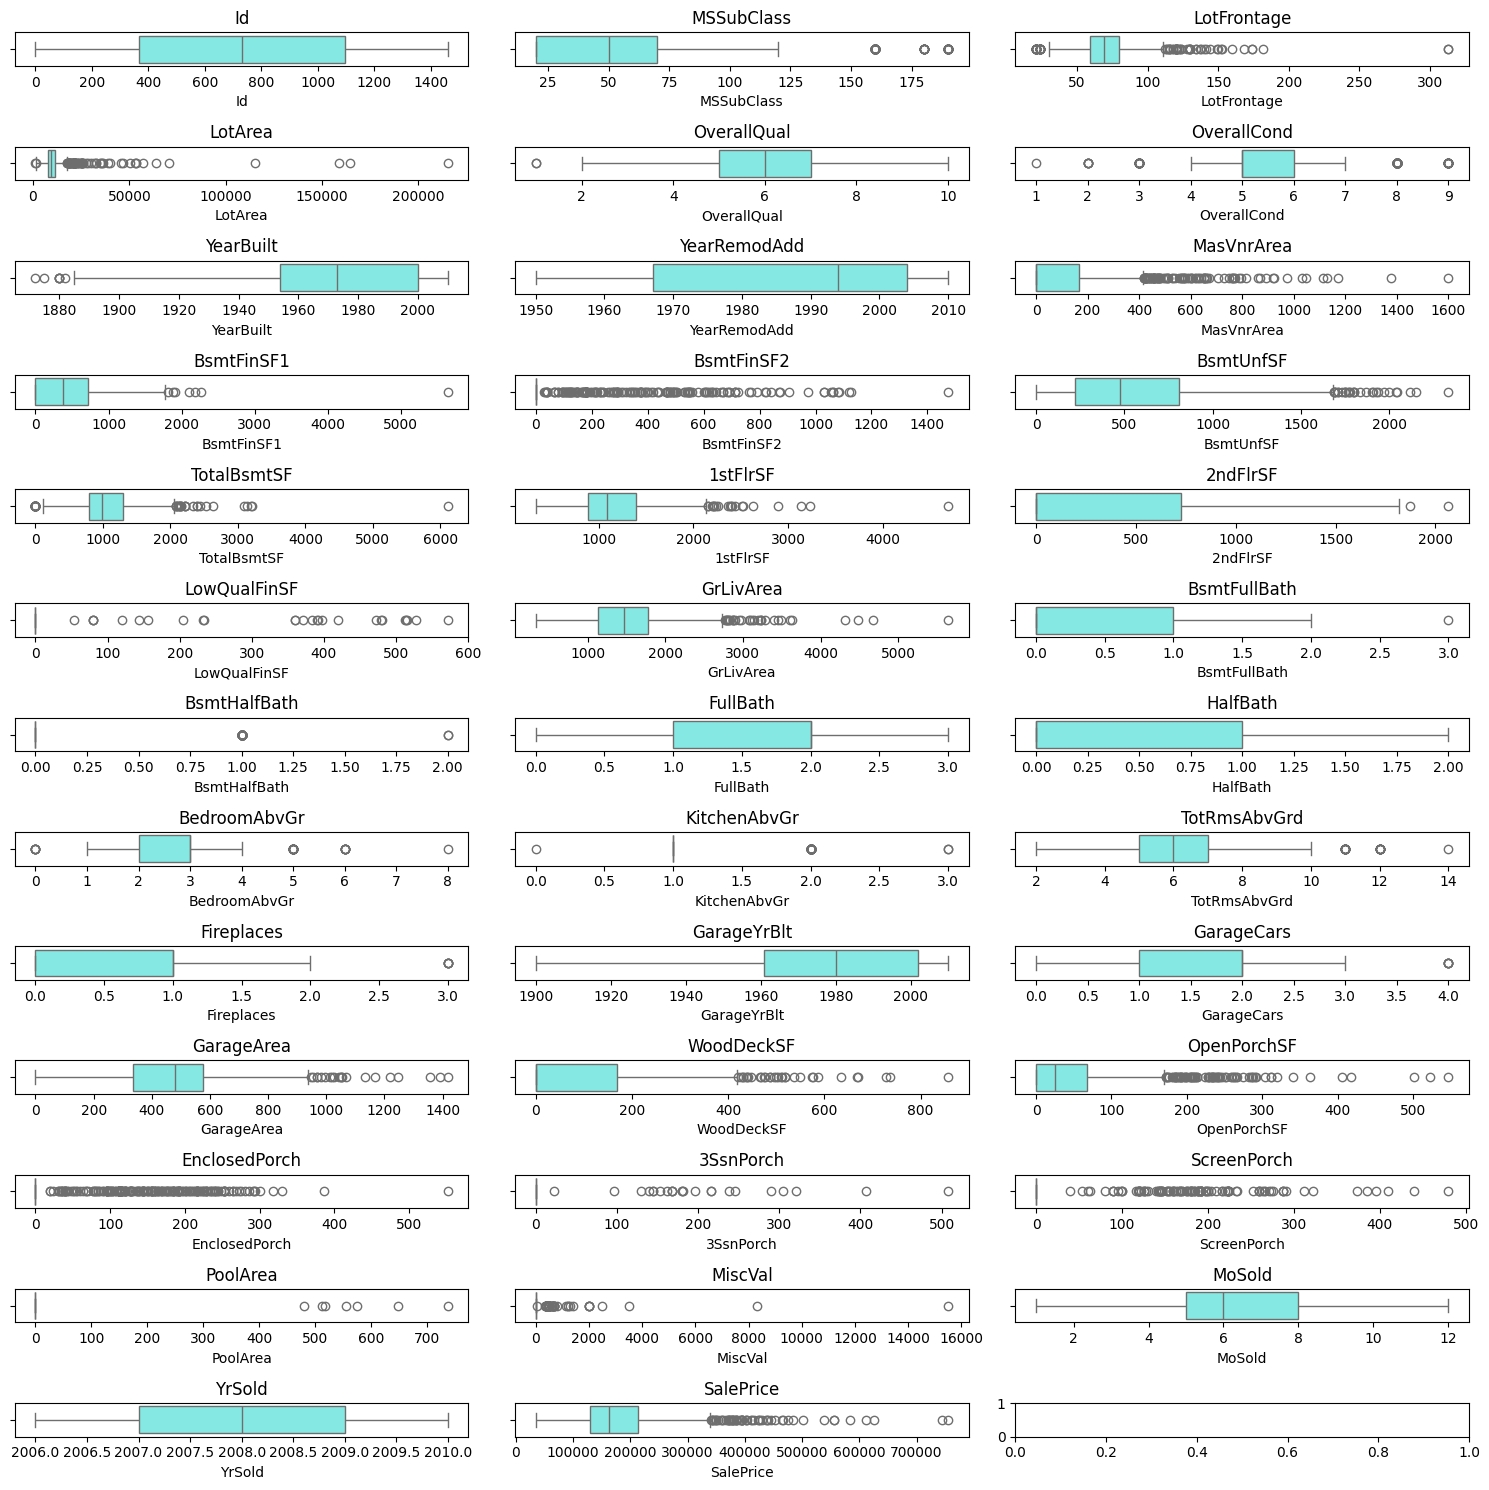

In [199]:
### Verificacion de outliers
num_features = df_train.select_dtypes(include=['int64', 'float64'])
def plot_grafico_outliers(num_features, df):

    fig, axes = plt.subplots(nrows=13, ncols=3, figsize=(15, 15))

    for i, feature in enumerate(num_features):
        row, col = divmod(i, 3)
        sns.boxplot(x=df[feature], ax=axes[row, col], color="#75f8f2")
        axes[row, col].set_title(feature)

    plt.tight_layout()
    plt.show()
plot_grafico_outliers(num_features,df_train)

##### Como se puede observar existen outliers dentro del dataset de training, sin embargo, como existen propiedades lujosas con variables fuera de lo comun podemos decir que esto no es un problema. Esto permitira que el modelo entienda la relacion real entre las caracteristicas y los precios de las casas.

In [200]:
#### Verificacion de inconsistencias en datos categoricos
def contar_valores_categoricos(df):
    # Recorre las columnas categóricas del DataFrame
    for col in df.select_dtypes(include=['object', 'category']):
        print(f'Valores únicos en la columna: {col}')
        print(df[col].value_counts())
        print('-' * 50)

##Se cambiar str to upper y strip utilizando metodo apply.
def modificar_valores_categoricos(df):
  for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].str.upper().str.strip()
  return df

df_train = modificar_valores_categoricos(df_train)
df_test = modificar_valores_categoricos(df_test)

contar_valores_categoricos(df_train)
contar_valores_categoricos(df_test)
### No se observan datos categoricos a los cuales se tengan que modificar por ser inconsistentes como Abnormal y Anormal


Valores únicos en la columna: MSZoning
MSZoning
RL         1151
RM          218
FV           65
RH           16
C (ALL)      10
Name: count, dtype: int64
--------------------------------------------------
Valores únicos en la columna: Street
Street
PAVE    1454
GRVL       6
Name: count, dtype: int64
--------------------------------------------------
Valores únicos en la columna: Alley
Alley
GRVL    50
PAVE    41
Name: count, dtype: int64
--------------------------------------------------
Valores únicos en la columna: LotShape
LotShape
REG    925
IR1    484
IR2     41
IR3     10
Name: count, dtype: int64
--------------------------------------------------
Valores únicos en la columna: LandContour
LandContour
LVL    1311
BNK      63
HLS      50
LOW      36
Name: count, dtype: int64
--------------------------------------------------
Valores únicos en la columna: Utilities
Utilities
ALLPUB    1459
NOSEWA       1
Name: count, dtype: int64
--------------------------------------------------
Va

In [201]:
### Verificar valores nulos
# Identificar valores faltantes
def identificar_valores_faltantes(df):
    print("Valores faltantes en el dataset")
    qsna = df.shape[0] - df.isnull().sum(axis=0)
    qna = df.isnull().sum(axis=0)
    ppna = round(100 * (df.isnull().sum(axis=0) / df.shape[0]), 2)

    # Crear DataFrame con los resultados
    aux = {'datos sin NAs en q': qsna, 'Na en q': qna, 'Na en %': ppna}
    na_df = pd.DataFrame(data=aux)

    # Ordenar el DataFrame por el porcentaje de valores faltantes
    return na_df.sort_values(by='Na en %', ascending=False)
###Codigo para habilitar la vista completa del dataframe
pd.set_option('display.max_rows', None)## habilitar el display de todas las filas
pd.set_option('display.max_columns', None)## habilitar el display de todas las columnas

###Imprimir los valores nulos
na_df_train = identificar_valores_faltantes(df_train)
na_df_test = identificar_valores_faltantes(df_test)
print("nVerificar NA de Valores en Train")
print(na_df_train)
print("nVerificar NA de Valores en Test")
print(na_df_test)

###Tanto en train como en test se encuentra un alto porcentaje de valores Nan en PoolQC, MiscFeature, Alley, Fence
##por lo que se procede a eliminar estas columnas

df_train=df_train.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence'])
df_test=df_test.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence'])

Valores faltantes en el dataset
Valores faltantes en el dataset
nVerificar NA de Valores en Train
               datos sin NAs en q  Na en q  Na en %
PoolQC                          7     1453    99.52
MiscFeature                    54     1406    96.30
Alley                          91     1369    93.77
Fence                         281     1179    80.75
MasVnrType                    588      872    59.73
FireplaceQu                   770      690    47.26
LotFrontage                  1201      259    17.74
GarageYrBlt                  1379       81     5.55
GarageCond                   1379       81     5.55
GarageType                   1379       81     5.55
GarageFinish                 1379       81     5.55
GarageQual                   1379       81     5.55
BsmtFinType2                 1422       38     2.60
BsmtExposure                 1422       38     2.60
BsmtQual                     1423       37     2.53
BsmtCond                     1423       37     2.53
BsmtFinType1      

### Ya que contamos con dataset separados en train y test, se procede a separar los valores de X e Y. En el caso de test no cuenta con la columna price por lo que solo seria x_test

In [202]:
# Definir X e y de train y test.
X_train = df_train.drop(columns=['SalePrice'])
y_train = df_train['SalePrice']
X_test = df_test
y_test = df_y_test['SalePrice']

print(X_train.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0   1          60       RL         65.0     8450   PAVE      REG         LVL   
1   2          20       RL         80.0     9600   PAVE      REG         LVL   
2   3          60       RL         68.0    11250   PAVE      IR1         LVL   
3   4          70       RL         60.0     9550   PAVE      IR1         LVL   
4   5          60       RL         84.0    14260   PAVE      IR1         LVL   

  Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
0    ALLPUB    INSIDE       GTL      COLLGCR       NORM       NORM     1FAM   
1    ALLPUB       FR2       GTL      VEENKER      FEEDR       NORM     1FAM   
2    ALLPUB    INSIDE       GTL      COLLGCR       NORM       NORM     1FAM   
3    ALLPUB    CORNER       GTL      CRAWFOR       NORM       NORM     1FAM   
4    ALLPUB       FR2       GTL      NORIDGE       NORM       NORM     1FAM   

  HouseStyle  OverallQual  OverallCond  Year

2. Exploración de Datos:

* Visualizaciones univariadas y multivariadas: Crea histogramas, gráficos de barras, diagramas de dispersión y mapas de calor para entender la distribución y las relaciones entre las variables.
* Estadísticas descriptivas: Calcula medidas de tendencia central (media, mediana, moda) y de dispersión (rango, desviación estándar) para cada característica del dataset.


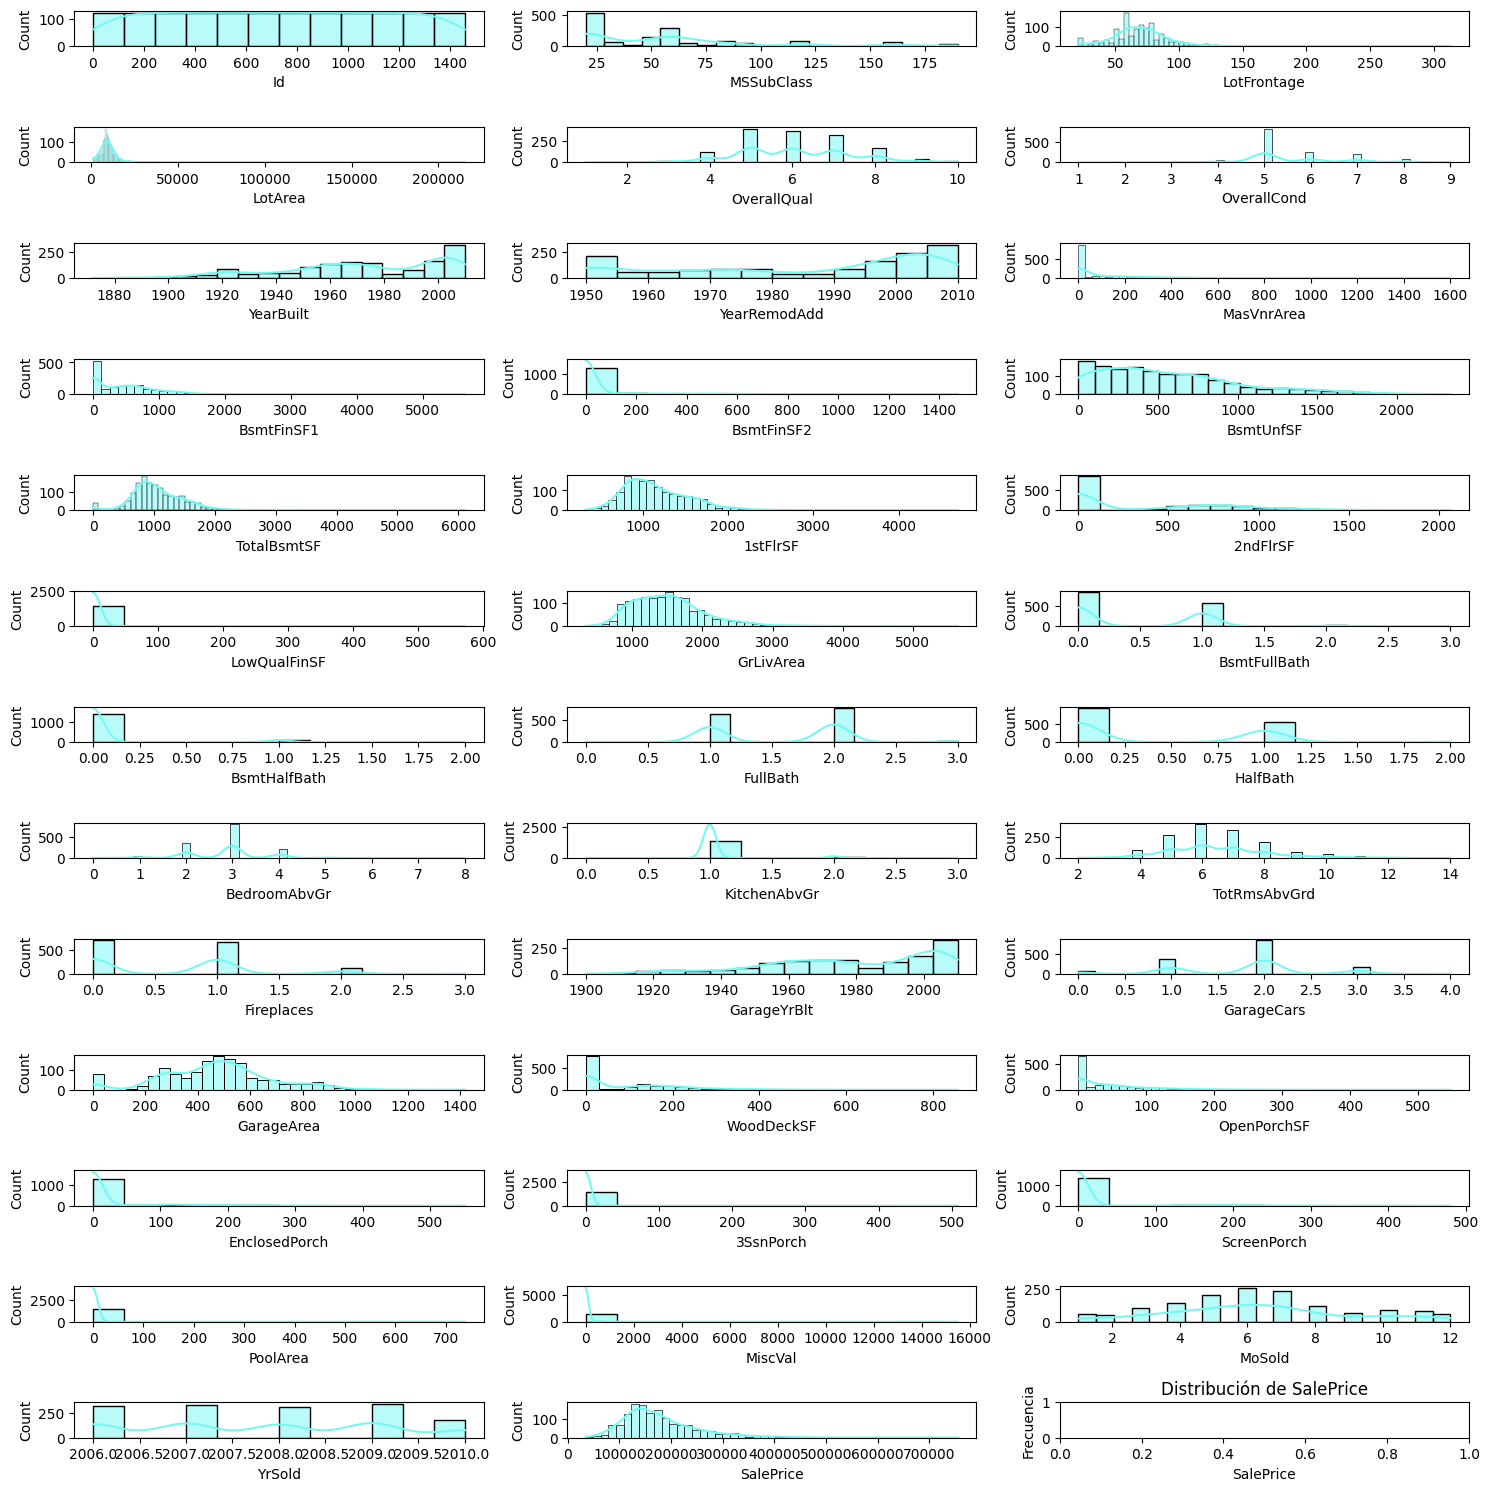

In [203]:
##Visualizacion univariadas y multivariadas##

# Histogramas para variables numéricas
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
target_variable = 'SalePrice'
fig, axes = plt.subplots(nrows=13, ncols=3, figsize=(15, 15))

for i, feature in enumerate(num_features):
      row, col = divmod(i, 3)
      sns.histplot(x=df[feature], ax=axes[row, col], kde=True, color="#75f8f2")
      plt.title(f'Distribución de {feature}')
      plt.xlabel(feature)
      plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

##### **Observaciones: ** Algunos histogramas muestran distribuciones normales (en forma de campana), mientras que otros pueden ser sesgados o tener valores atípicos. A continuacion se da algunas ponderaciones respecto a los hisogramas:
* La variable target SalePrice tiene una distribución asimétrica hacia la derecha, típica de precios de bienes raíces (la mayoría de las casas tienen precios promedio o bajos, mientras que unas pocas tienen precios muy altos).
* MSSubClass, OverallQual, OverallCond, Fireplaces, GarageCars: Estas variables tienen un número limitado de valores discretos y son más categóricas que continuas.
* Los histogramas como los de LotFrontage, LotArea, GrLivArea, y MasVnrArea confirman que hay outliers significativos.
* LowQualFinSF, BsmtHalfBath, 3SsnPorch, PoolArea, MiscVal: Estas variables tienen distribuciones muy concentradas (en su mayoría ceros o valores bajos), podrian no aportar mucho al modelo.

<ipython-input-204-1a6488e98c50>:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-204-1a6488e98c50>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-204-1a6488e98c50>:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-204-1a6488e98c50>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-204-1a6488e98c50>:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-204-1a6488e98c50>:15: FutureWarning: 

Passing `palette` without assigning `hue`

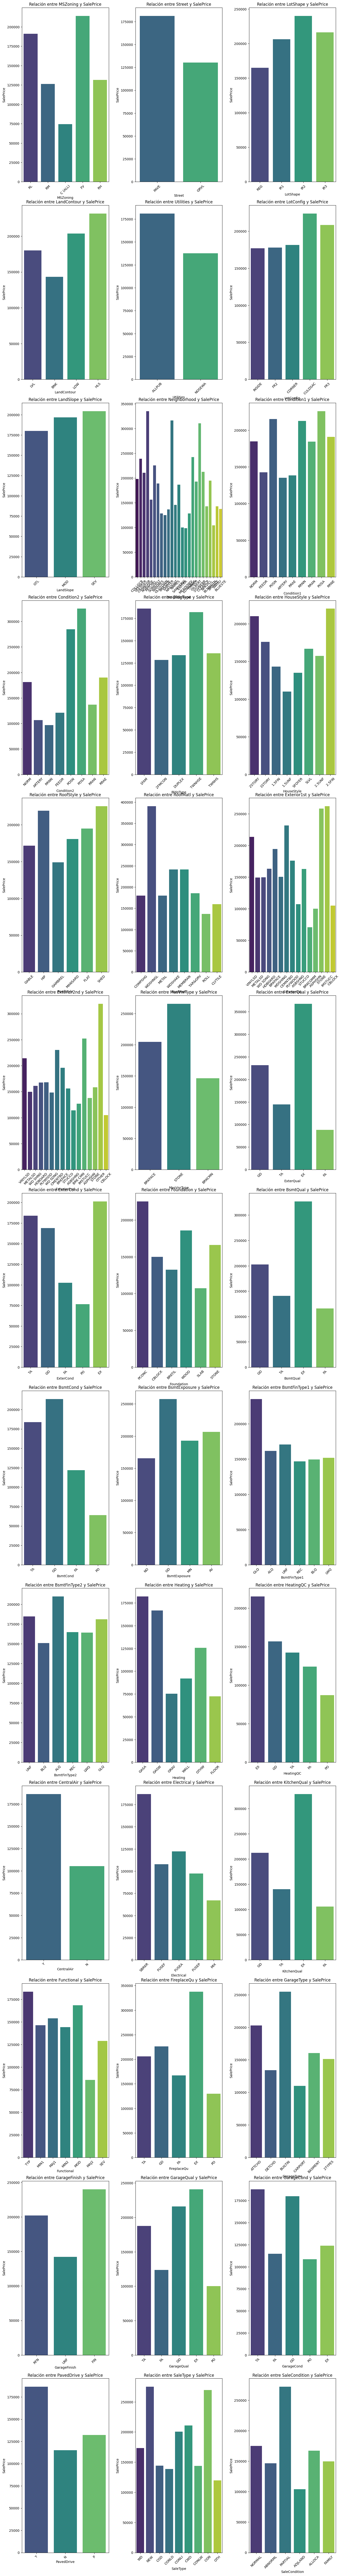

In [204]:
# Variables categóricas
categorical_features = df_train.select_dtypes(include=['object', 'category']).columns
target_variable = 'SalePrice'  # Reemplaza por el nombre de tu variable objetivo

# Crear subplots dinámicamente
num_features = len(categorical_features)
fig, axes = plt.subplots(nrows=(num_features // 3) + 1, ncols=3, figsize=(15, num_features * 3))

# Ajustar espaciado
fig.tight_layout(pad=5)

# Iterar sobre cada variable categórica
for i, feature in enumerate(categorical_features):
    row, col = divmod(i, 3)  # Posición del subplot
    sns.barplot(
        data=df_train,
        x=feature,
        y=target_variable,
        ax=axes[row, col],
        palette="viridis",
        ci=None  # Evita los intervalos de confianza para claridad
    )
    axes[row, col].set_title(f'Relación entre {feature} y {target_variable}')
    axes[row, col].tick_params(axis='x', rotation=45)  # Rotar etiquetas del eje X

# Eliminar subplots vacíos
for j in range(i + 1, len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

plt.show()


##### Se puede observar que las variables categoricas con barras mas altas pueden representar valores significativos en la prediccion de precios de una propiedad. Basandonos en esta observacion se puede decir que las siguientes variables son importantes para la prediccion:
* Características de la propiedad: Número de habitaciones, baños, tamaño del lote, tipo de construcción, etc.
* Ubicación: Zona, vecindario, código postal, etc.
* Condiciones de la propiedad: Edad de la propiedad, estado de conservación, etc.
* Características adicionales: Piscina, garaje, sótano, etc.

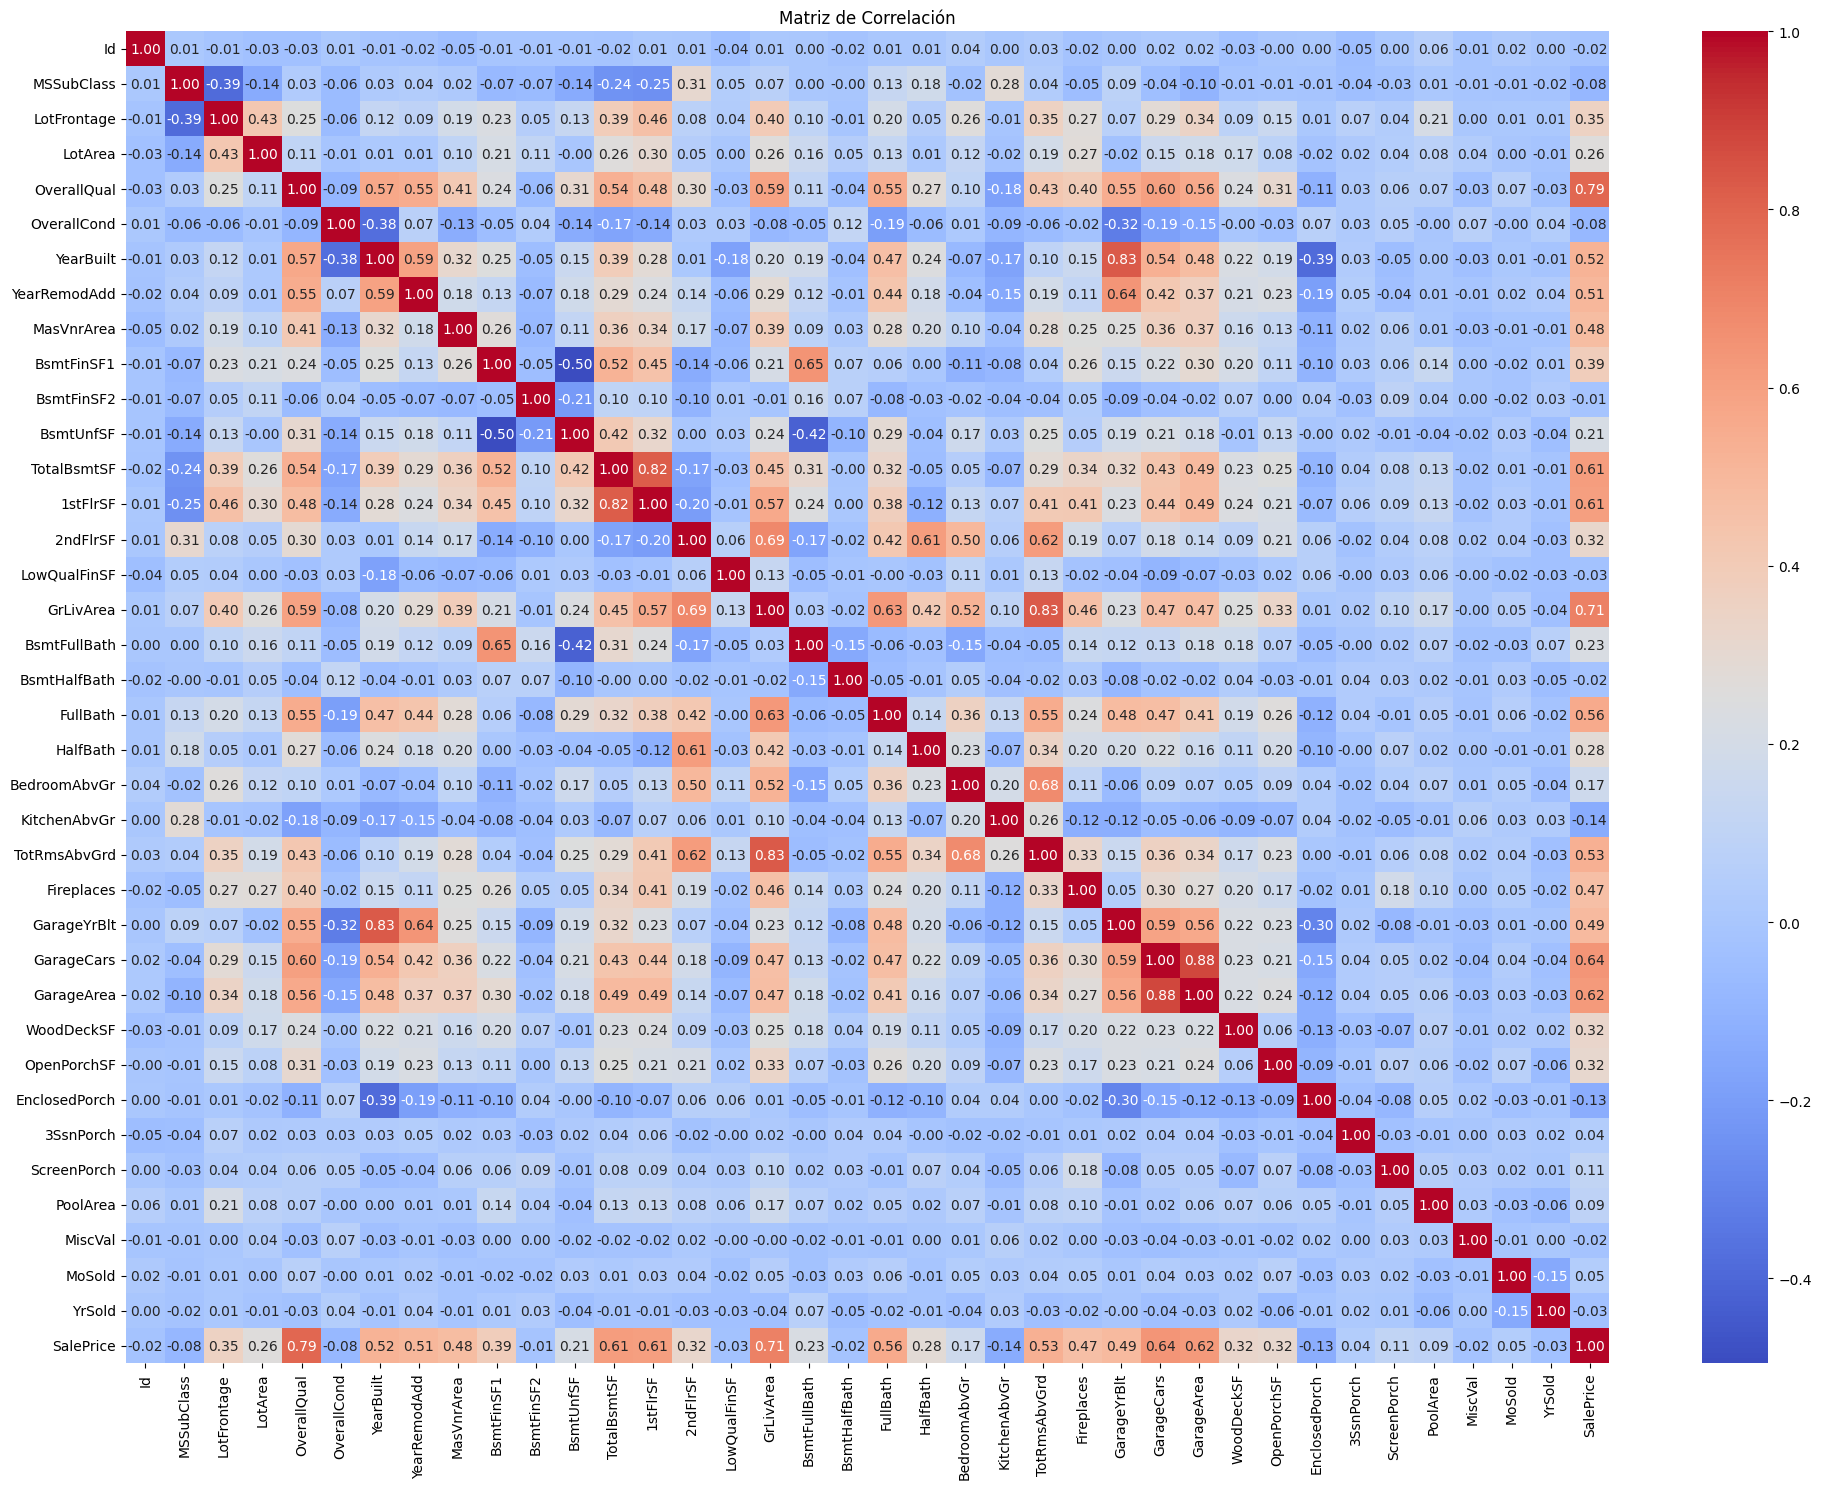

In [205]:
 # Mapa de calor para la correlación entre variables numéricas
plt.figure(figsize=(20, 15))
correlation_matrix = df_train[numeric_features + [target_variable]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

##### En este grafico de correlacion se puede observar que en relacion a nuestra variable target la variable OverallQua tiene mayor relacion positiva con 0.79, seguida de GirLivArea con 0.71 los cuales son los mas altos luego entre el 0.61 al 0.64 se encuentran GarageCars, GarageArea, TotalBsmntSF, 1stFlrSF, las demas ya llegan por debajo de los 60 por lo que no se consideran relevantes. En caso de las variables negativas -0.14 es una variable negativamente mayor por lo que se consideran debiles para una relacion lineal.

In [206]:
### Estadistica descriptiva
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


De esta estadistica descriptiva se puede observar lo siguiente:
* Hay una gran variabilidad en muchas de las características de las propiedades (como el tamaño del lote, la calidad general, y las áreas habitables), lo que sugiere que el conjunto de datos contiene propiedades de diferentes tipos, tamaños y condiciones.

* Las áreas de sótano y las áreas habitables tienen una amplia gama de valores, lo que podría ser importante si estás analizando la relación entre el tamaño de la casa y su precio o calidad.

* Las variables relacionadas con el tamaño físico de las propiedades (como LotArea, GrLivArea, y BsmtFinSF1) tienen desviaciones estándar altas, lo que sugiere una diversidad considerable en el tipo de propiedades incluidas en el conjunto de datos. Por otro lado, las variables cualitativas como OverallQual y OverallCond tienen desviaciones estándar bajas, lo que indica una mayor homogeneidad en la calidad y la condición de las propiedades.

In [210]:
### Imputacion de valores faltantes y utilizacion de pipeline para modificar valores catogoricos
###Pipeline para preprocesamiento de valores
###Luego de la verificacion de las diferentes variables se puede tomar las siguientes variables como seleccion de features
selected_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF',  # Example features
                     'FullBath', 'YearBuilt', '1stFlrSF', 'YearRemodAdd',
                     'GarageArea','Fireplaces','LotArea','Neighborhood',
                     'Condition2','RoofMatl','Exterior2nd','FireplaceQu',
                     'KitchenQual','BsmtQual']

# Crear un nuevo DataFrame solo con los features seleccionados.
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
# Definir transformaciones
numeric_features = X_train_selected.select_dtypes(include=['float64', 'int']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# En este dataset no hay categóricas, pero se puede añadir una columna categórica ficticia para la práctica
categorical_features = X_train_selected.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Integrar en un pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Aplicar preprocesamiento
X_transformed = pipeline.fit_transform(X_train_selected,y_train)
print("Preprocesamiento completado. Datos transformados listos para modelar.")

Preprocesamiento completado. Datos transformados listos para modelar.


3. Implementación de Modelos:

* Modelos de Regresión: Implementa modelos de Linear Regression y LightGBM (LGBM).
* Evaluación de Modelos: Evalúa los modelos utilizando métricas como MSE, RMSE, y R^2.
* Comparación de Rendimiento: Compara los resultados de ambos modelos y discute cuál es el más adecuado para este dataset.


In [211]:
# Crear y aplicar el pipeline a los datos de entrenamiento
X_train_transformed = pipeline.fit_transform(X_train_selected)

# Aplicar la misma transformación a los datos de prueba (sin hacer fit)
X_test_transformed = pipeline.transform(X_test_selected)

# Crear y entrenar el modelo de regresión lineal con los datos transformados
modelo = LinearRegression()
modelo.fit(X_train_transformed, y_train)

# Realizar predicciones con los datos de prueba transformados
y_pred = modelo.predict(X_test_transformed)

# Evaluar el modelo
mseLR = mean_squared_error(y_test, y_pred)
rmseLR = mean_squared_error(y_test, y_pred, squared=False)  # RMSE es la raíz cuadrada del MSE
r2LR = r2_score(y_test, y_pred)
maeLR = mean_absolute_error(y_test, y_pred)

# Imprimir los resultados de evaluación
print(f'Mean Squared Error (MSE): {mseLR}')
print(f'Root Mean Squared Error (RMSE): {rmseLR}')
print(f'R-squared (R^2): {r2LR}')
print(f'Mean Absolute Error (MAE): {maeLR}')


Mean Squared Error (MSE): 5360430758.973631
Root Mean Squared Error (RMSE): 73214.9626713941
R-squared (R^2): -18.659234330600004
Mean Absolute Error (MAE): 55822.607385581265


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [212]:
# Crear el modelo LightGBM
modelo_lgb = lgb.LGBMRegressor()

# Entrenar el modelo con los datos transformados
modelo_lgb.fit(X_train_transformed, y_train)

# Realizar predicciones con los datos de prueba
y_pred_lgb = modelo_lgb.predict(X_test_transformed)

# Evaluar el modelo
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mse_lgb)  # RMSE es la raíz cuadrada de MSE
r2_lgb = r2_score(y_test, y_pred_lgb)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)

# Imprimir los resultados de evaluación
print(f'Mean Squared Error (MSE): {mse_lgb}')
print(f'Root Mean Squared Error (RMSE): {rmse_lgb}')
print(f'R-squared (R^2): {r2_lgb}')
print(f'Mean Absolute Error (MAE): {mae_lgb}')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1553
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 56
[LightGBM] [Info] Start training from score 180921.195890
Mean Squared Error (MSE): 5340684778.565454
Root Mean Squared Error (RMSE): 73079.98890644041
R-squared (R^2): -18.58681648334362
Mean Absolute Error (MAE): 55304.94280945887


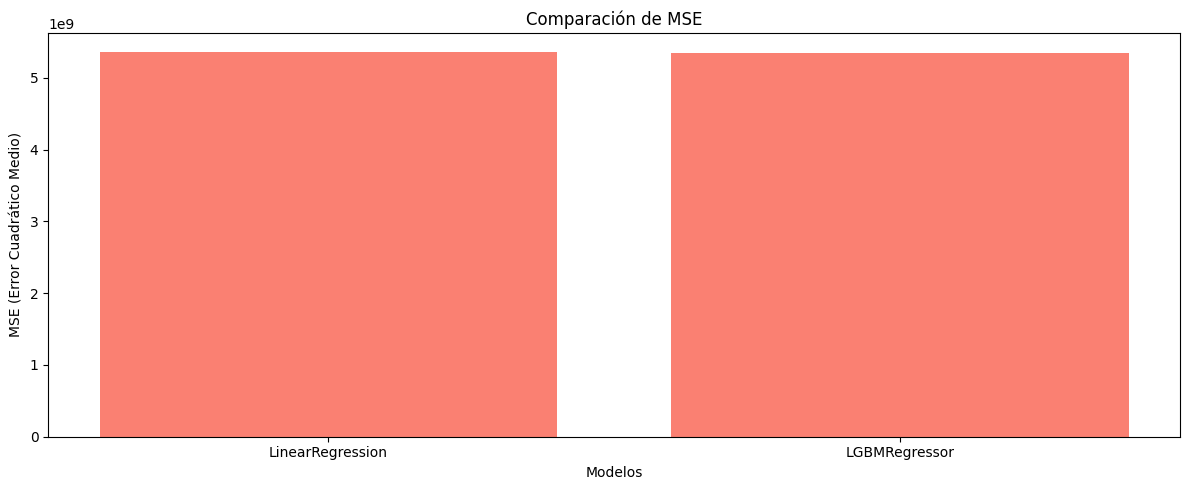

In [217]:
# Crear la figura
fig = plt.figure(figsize=(12, 5))

# Agregar un subgráfico (axes) a la figura
ax = fig.add_subplot(111)  # 111 significa 1 fila, 1 columna, primer subgráfico

# Gráfico de barras para el MSE
ax.bar(model_names, mse_values, color='salmon')
ax.set_title('Comparación de MSE')
ax.set_xlabel('Modelos')
ax.set_ylabel('MSE (Error Cuadrático Medio)')

plt.tight_layout()
plt.show()

## Resumen de resultados:

* MSE: Ambos modelos, Linear Regression (MSE: 5360430758.97) y LightGBM (MSE: 5340684778.57), tienen errores cuadráticos medios similares, lo que sugiere que ninguno de los dos está haciendo predicciones significativamente mejores que el otro.

* RMSE: Los errores absolutos también son similares (LR: 73214.96, LightGBM: 73079.99), lo que implica que la magnitud del error es comparable entre ambos modelos.

* R²: Ambos modelos tienen valores de R² negativos (LR: -18.66, LightGBM: -18.59), lo que indica que los modelos están fallando en capturar la variabilidad de los datos. En general, un R² negativo sugiere que los modelos están realizando predicciones peores que simplemente predecir la media de los valores.

* MAE: El Error Absoluto Medio (MAE) también es muy similar (LR: 55822.61, LightGBM: 55304.94), lo que indica que el tamaño promedio del error es comparable en ambos modelos.

### Sugerencias de futuras implementaciones
* Realizar un feature engineering para seleccionar mejores features
* Modificar los hyperparametros, probarlos con gridsearch
* Evaluar con otros modelos.